In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, LearningCurveDisplay, learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE

import shap
shap.initjs()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)

# KDDCup1999

In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate"]
label = ["label"]
X_train = pd.read_csv('./data/kddcup/X_train_res.csv', index_col=False)
y_train = pd.read_csv('./data/kddcup/y_train_res.csv', index_col=False)
X_test = pd.read_csv('./data/kddcup/X_test.csv', index_col=False)
y_test = pd.read_csv('./data/kddcup/y_test.csv', index_col=False)

In [3]:
y_train.value_counts()

label
0        2748096
1        2748096
Name: count, dtype: int64

Labels:  
0 = normal  
1 = attack

In [4]:
X_train.shape, X_test.shape

((5496192, 41), (1469530, 41))

## Select 15 best features

In [5]:
selected_features = [
    'protocol_type', 'service', 'flag', 'logged_in', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate'
]
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print("Original number of features:", X_train.shape[1])
print("Number of selected features:", X_train_sel.shape[1])
print("Number of training samples:", X_train_sel.shape[0])
print("Number of test samples:", X_test_sel.shape[0])

Original number of features: 41
Number of selected features: 15
Number of training samples: 5496192
Number of test samples: 1469530


## Scale data

In [18]:
scaler = StandardScaler()
X_train_sel_scaled = scaler.fit_transform(X_train_sel, y_train)
X_test_sel_scaled = scaler.fit_transform(X_test_sel, y_test)

## Model Training

In [24]:
# Function to print classification reports and plot confusion matrix and ROC curve
def print_reports(clf, X_test, y_test, y_pred, classes, title):
    print(title)
    # print classification report
    print(classification_report(y_test, y_pred))
    
    print()
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print()
    
    # plot ROC curve
    roc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)

### Baseline performance

SGD Classifier Confusion Matrix
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    291976
           1       1.00      0.97      0.98   1177554

    accuracy                           0.97   1469530
   macro avg       0.94      0.98      0.96   1469530
weighted avg       0.98      0.97      0.97   1469530




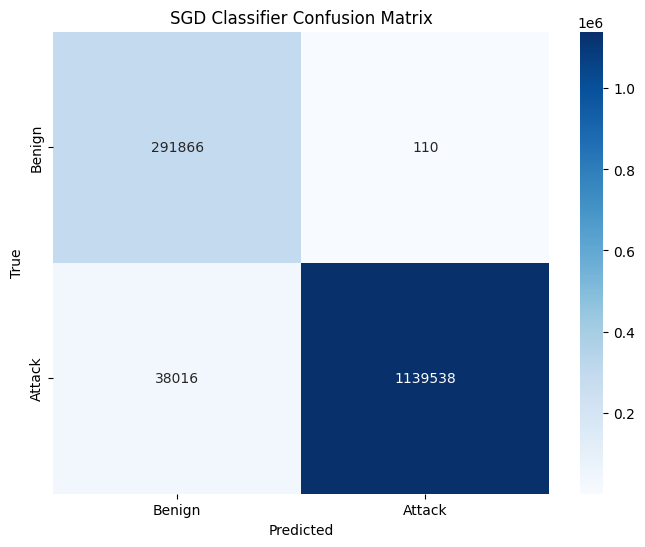


CPU times: user 36.6 s, sys: 2.23 s, total: 38.9 s
Wall time: 39.6 s


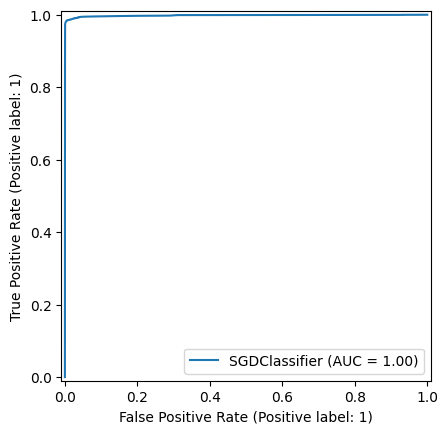

In [25]:
%%time
sgd_clf = SGDClassifier(max_iter=1000)
sgd_clf.fit(X_train, y_train.values.ravel())
sgd_pred = sgd_clf.predict(X_test)
print_reports(sgd_clf, X_test, y_test, sgd_pred, ['Benign', 'Attack'], 'SGD Classifier Confusion Matrix')

### After feature selection and hyperparameter tuning

In [30]:
%%time
clf = SGDClassifier(max_iter=5000, penalty='elasticnet', loss='hinge', alpha=0.0001)
clf.fit(X_train_sel, y_train.values.ravel())
y_pred = clf.predict(X_test_sel)

CPU times: user 55.5 s, sys: 660 ms, total: 56.1 s
Wall time: 1min


SGD Confusion Matrix w/ 15 best features and hyperparameter tuning
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    291976
           1       1.00      0.99      0.99   1177554

    accuracy                           0.99   1469530
   macro avg       0.98      0.99      0.99   1469530
weighted avg       0.99      0.99      0.99   1469530




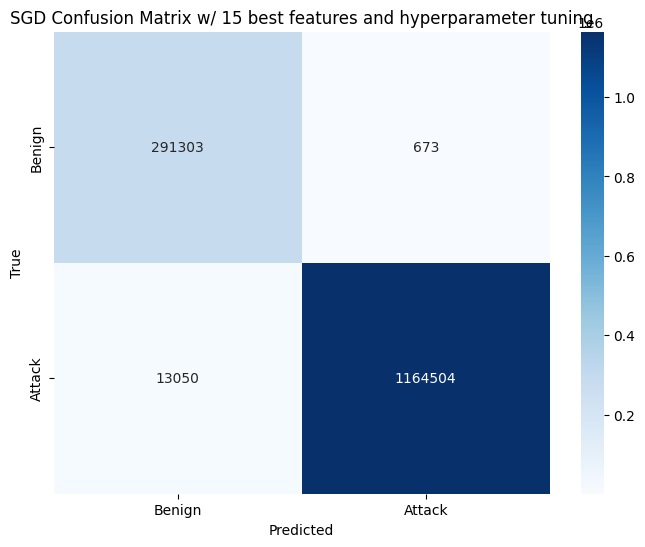

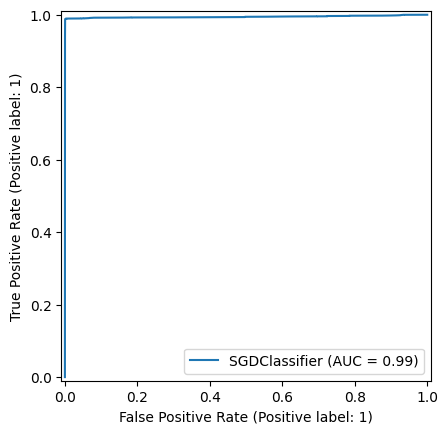

In [31]:
print_reports(clf, X_test_sel, y_test, y_pred, ['Benign', 'Attack'], 'SGD Confusion Matrix w/ 15 best features and hyperparameter tuning')

### Cross Validation

In [32]:
cv = StratifiedKFold(5)
scores = cross_val_score(clf, X_train_sel, y_train.values.ravel(), cv=cv)
scores

array([0.99345911, 0.99373112, 0.99392033, 0.99361649, 0.99261488])

(0.99, 0.995)

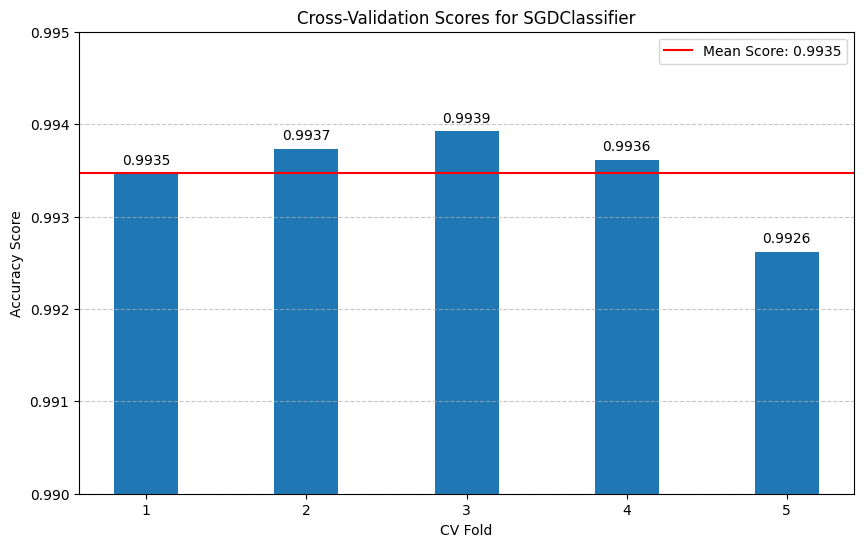

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(scores) + 1), scores, width=0.4)
plt.xlabel('CV Fold')
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Scores for SGDClassifier')

mean_score = np.mean(scores)
plt.axhline(y=mean_score, color='r', linestyle='-', label=f'Mean Score: {mean_score:.4f}')

for i, score in enumerate(scores):
    plt.text(i + 1, score + 0.0001, f'{score:.4f}', ha='center')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.99, 0.995)  # Assuming scores are between 0 and 1

## Explanations

In [132]:
# # Define a function to convert decision function to probabilities (sigmoid)
# def predict_proba_sgd(X):
#     decision_scores = clf.decision_function(X)  # Get decision function output
#     return 1 / (1 + np.exp(-decision_scores))  # Sigmoid to convert to probabilities

In [150]:
explainer = shap.KernelExplainer(clf.predict, X_train_sel[:100])

#np.random.seed(42)
#sample_indices = np.random.choice(X_test_sel.shape[0], size=100000, replace=False)
#X_sample = X_test_sel.iloc[sample_indices]

shap_values = explainer(X_test_sel[100:200])

  0%|          | 0/100 [00:00<?, ?it/s]

In [145]:
np.shape(shap_values)

(100, 15)

### Waterfall Plot

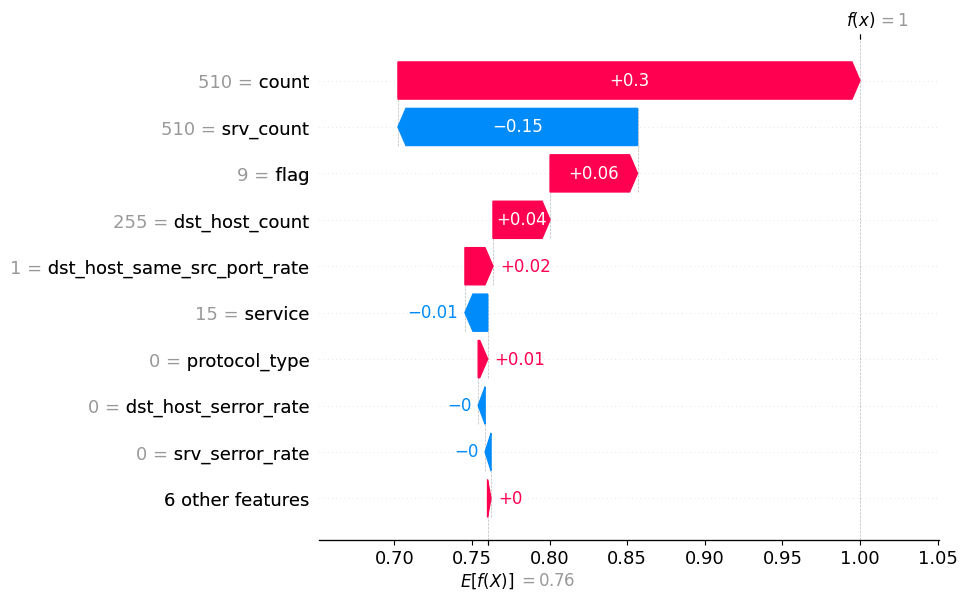

In [152]:
shap.plots.waterfall(shap_values[0])

### Absolute Mean SHAP values

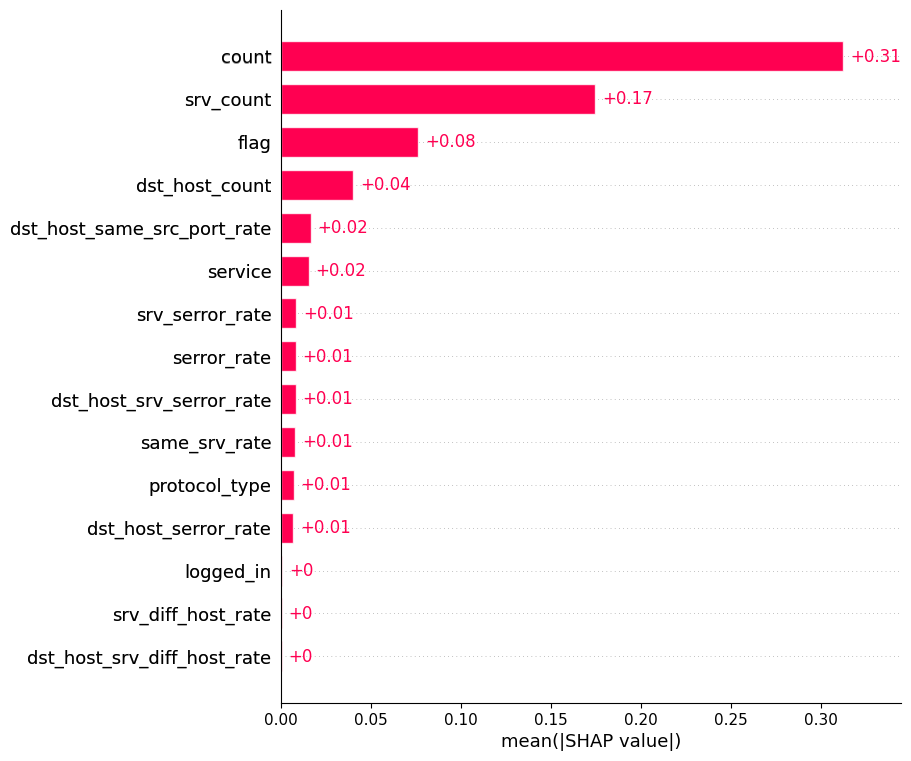

In [153]:
shap.plots.bar(shap_values, max_display=15)

### Beeswarm plot

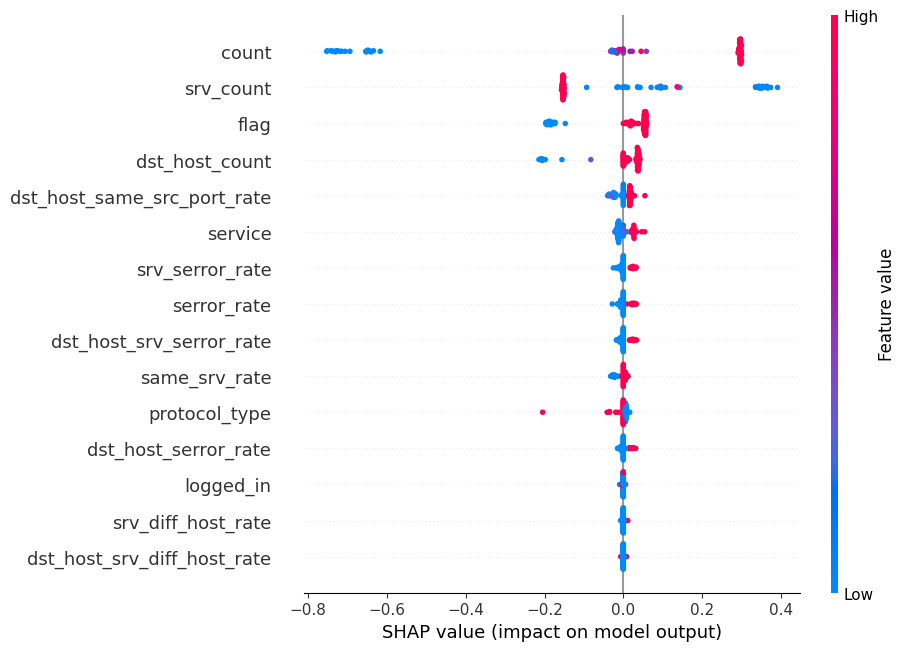

In [187]:
shap.plots.beeswarm(shap_values, max_display=15)

### Dependence Plot

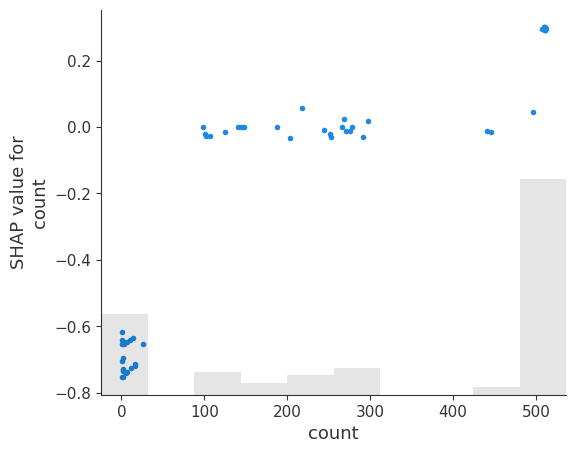

In [190]:
shap.plots.scatter(shap_values[:,"count"])